# Libraries

In [1]:
#import modin.pandas as pd
import warnings
import pandas as pds
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import resample
from pandas_profiling import ProfileReport
import pyforest
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score
from lazypredict.Supervised import LazyRegressor
pd.options.display.max_columns = 100
#pd.set_option('display.max_columns', None)

C:\Users\user\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


<IPython.core.display.Javascript object>

# Import, Clean, Merge your Key Table

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

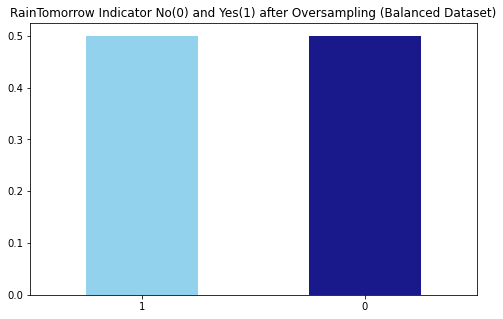

In [2]:
#Import key_table
rain_aus = pd.read_csv("C:/Users/user/2. GIT_PROJECTS/Desafios/Projeto 4 - Itau/case/data/rain_data_aus.csv")
rain_aus = rain_aus.rename(columns={"amountOfRain": "amntraintmrw"})
rain_aus['raintoday'].replace({'No': 0, 'Yes': 1},inplace = True)
rain_aus['raintomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)
rain_aus.head()
#Resample and resize variable
no = rain_aus[rain_aus.raintomorrow == 0]
yes = rain_aus[rain_aus.raintomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
rain_oversample = pd.concat([no, yes_oversampled])
#Plot and see resample
fig = plt.figure(figsize = (8,5))
rain_oversample.raintomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

In [3]:
#Import side_tables and concatenate in one
wind1 = pd.read_csv("C:/Users/user/2. GIT_PROJECTS/Desafios/Projeto 4 - Itau/case/data/wind_table_01.csv")
wind2 = pd.read_csv("C:/Users/user/2. GIT_PROJECTS/Desafios/Projeto 4 - Itau/case/data/wind_table_02.csv")
wind3= pd.read_csv("C:/Users/user/2. GIT_PROJECTS/Desafios/Projeto 4 - Itau/case/data/wind_table_03.csv")
wind4 = pd.read_csv("C:/Users/user/2. GIT_PROJECTS/Desafios/Projeto 4 - Itau/case/data/wind_table_04.csv")
wind5 = pd.read_csv("C:/Users/user/2. GIT_PROJECTS/Desafios/Projeto 4 - Itau/case/data/wind_table_05.csv")
wind6 = pd.read_csv("C:/Users/user/2. GIT_PROJECTS/Desafios/Projeto 4 - Itau/case/data/wind_table_06.csv")
wind7 = pd.read_csv("C:/Users/user/2. GIT_PROJECTS/Desafios/Projeto 4 - Itau/case/data/wind_table_07.csv")
wind8 = pd.read_csv("C:/Users/user/2. GIT_PROJECTS/Desafios/Projeto 4 - Itau/case/data/wind_table_08.csv")
wind = pd.concat([wind1, wind2, wind3, wind4, wind5, wind6, wind7, wind8])
#Correct merged side_tables
cont = 2
for col in wind.columns[8:14]:
    wind.loc[~wind[col].isnull(), wind.columns[cont]] = wind.loc[~wind[col].isnull(), col]
    cont +=1
wind = wind.drop(['windgustdir', 'windgustspeed', 'winddir9am', 'winddir3pm', 'windspeed9am', 'windspeed3pm'], axis=1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
#Merge all tables and apply conditions to correct it
rain_merge = pd.merge(left=rain_aus, right=wind, how='left', on=['date', 'location'])
rain_merge['date'] = pd.to_datetime(rain_merge['date'].str.strip(), format='%Y/%m/%d')
rain_merge.loc[(rain_merge.amntraintmrw < 0.4),'amntraintmrw']=0
#Duplicates
    #rain_merge.groupby(rain_merge.columns.tolist(),as_index=False).size())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
#Correct type from columns
rain_merge['wind_gustdir'] = rain_merge['wind_gustdir'].astype(str)
rain_merge['wind_dir9am'] = rain_merge['wind_dir9am'].astype(str)
rain_merge['wind_dir3pm'] = rain_merge['wind_dir3pm'].astype(str)
#turn it into a scale
encoder = LabelEncoder()
encoder.fit(rain_merge['wind_gustdir'])
#transform
rain_merge['wind_gustdir'] = encoder.transform(rain_merge['wind_gustdir'])
rain_merge['wind_dir9am'] = encoder.transform(rain_merge['wind_dir9am'])
rain_merge['wind_dir3pm'] = encoder.transform(rain_merge['wind_dir3pm'])

In [6]:
#see min and max from table
print(rain_merge['date'].min())
print(rain_merge['date'].max())

2007-11-01 00:00:00
2017-06-25 00:00:00


In [7]:
#Create a table by your current season (apply one month ago + actual month + next month)
seasoned_rain = rain_merge[(rain_merge['date'].dt.month == 4) | (rain_merge['date'].dt.month == 5) | (rain_merge['date'].dt.month == 6)]
seasoned_rain = seasoned_rain[~(seasoned_rain['date'].dt.year <= 2007)]
#seasoned_rain = seasoned_rain[~(seasoned_rain['date'].dt.year >= 2017)]
#Export your table cleaned
rain_aus.to_csv('C:/Users/user/2. GIT_PROJECTS/Desafios/Projeto 4 - Itau/case/data/rain_cleaned.csv', index = False, header=True)

In [8]:
#Check your final table!
seasoned_rain

,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,amntraintmrw,raintomorrow,temp,humidity,precipitation3pm,precipitation9am,modelo_vigente,wind_gustdir,wind_gustspeed,wind_dir9am,wind_dir3pm,wind_speed9am,wind_speed3pm
120,2009-04-01,Albury,12.20,30.60,0.00,nan,nan,59.00,22.00,1022.60,1019.40,nan,nan,16.60,29.50,0.00,0.00,0,38.72,28.40,9,14.68,0.00,9,22.00,16,1,0.00,6.00
121,2009-04-02,Albury,14.30,32.10,0.00,nan,nan,59.00,30.00,1022.60,1018.40,nan,nan,18.40,30.90,0.00,8.60,1,40.52,38.00,17,11.36,0.37,4,28.00,16,1,0.00,11.00
122,2009-04-03,Albury,18.40,28.10,8.60,nan,nan,92.00,49.00,1018.80,1012.90,8.00,6.00,19.00,27.40,1.00,12.60,1,35.72,60.80,14,6.21,0.61,13,98.00,0,5,7.00,17.00
123,2009-04-04,Albury,10.70,21.40,12.60,nan,nan,60.00,33.00,1019.80,1019.30,nan,nan,13.90,20.30,1.00,0.00,0,27.68,41.60,5,12.26,0.02,13,43.00,16,15,0.00,13.00
124,2009-04-05,Albury,7.80,21.70,0.00,nan,nan,72.00,37.00,1020.40,1016.50,nan,nan,12.90,21.20,0.00,0.00,0,28.04,46.40,11,17.19,0.02,15,31.00,0,7,6.00,19.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164381,2017-06-22,Uluru,3.60,25.30,0.00,nan,nan,56.00,21.00,1023.50,1019.10,nan,nan,10.90,24.50,0.00,0.00,0,32.36,27.20,9,19.72,0.02,6,22.00,9,3,13.00,9.00
164382,2017-06-23,Uluru,5.40,26.90,0.00,nan,nan,53.00,24.00,1021.00,1016.80,nan,nan,12.50,26.10,0.00,0.00,0,34.28,30.80,12,0.99,0.01,3,37.00,9,14,9.00,9.00
164383,2017-06-23,Uluru,5.40,26.90,0.00,nan,nan,53.00,24.00,1021.00,1016.80,nan,nan,12.50,26.10,0.00,0.00,0,34.28,30.80,12,0.99,0.01,3,37.00,9,14,9.00,9.00
164384,2017-06-24,Uluru,7.80,27.00,0.00,nan,nan,51.00,24.00,1019.40,1016.50,3.00,2.00,15.10,26.00,0.00,0.00,0,34.40,30.80,15,4.38,0.02,9,28.00,10,3,13.00,7.00


# If you want to explore your data with graphs (TAKES TIME!!)

In [9]:
#Check pairplot if you want to analyze it(takes time to process it!!)
    #pairplot = sns.pairplot(rain_merge)
    #fig = pairplot.get_figure()
    #fig.savefig("rain_merge.png")

In [10]:
#Check pairplot if you want to analyze it(takes time to process it!!)
    #pairplot = sns.pairplot(seasoned_rain)
    #fig = pairplot.get_figure()
    #fig.savefig("seasoned_rain.png") 

In [11]:
#Export an automated exploratory analysys (takes time to process it!!)
#prof = ProfileReport(rain_merge, title="Rain in Austraia Seasoned Report", explorative=True)
#prof.to_file(output_file='Australia Rain Seasoned Report.html')

Summarize dataset:   0%|          | 0/42 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Predict the future!

In [114]:
#Create you best model variables
X = seasoned_rain[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = seasoned_rain['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=50, learning_rate=0.2, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9336688298760467
ROC_AUC_SCORE TEST IS:   0.9038391543531873


In [13]:
#If you want to compare with other model (REALLY HEAVY JOB, TAKES TIME!)
    #reg = LazyRegressor(ignore_warnings=False, custom_metric=None)
    #models, predictions = reg.fit(X_train, X_test, y_train, y_test)

In [14]:
#Try to undersample or oversample more your table by historical series
    #no = rain_merge[rain_merge.date > 3000]
    #yes = rain_merge[rain_merge.date <= 3000]
    #yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
    #rain_oversample = pd.concat([no, yes_oversampled])

    #fig = plt.figure(figsize = (8,5))
    #rain_oversample.date.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
    #plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
    #plt.show()


# By City

In [15]:
dfs = dict(tuple(seasoned_rain.groupby('location')))
cities_list = list(dfs)
print(cities_list)

['Adelaide', 'Albany', 'Albury', 'AliceSprings', 'BadgerysCreek', 'Ballarat', 'Bendigo', 'Brisbane', 'Cairns', 'Canberra', 'Cobar', 'CoffsHarbour', 'Dartmoor', 'Darwin', 'GoldCoast', 'Hobart', 'Katherine', 'Launceston', 'Melbourne', 'MelbourneAirport', 'Mildura', 'Moree', 'MountGambier', 'MountGinini', 'Newcastle', 'Nhil', 'NorahHead', 'NorfolkIsland', 'Nuriootpa', 'PearceRAAF', 'Penrith', 'Perth', 'PerthAirport', 'Portland', 'Richmond', 'Sale', 'SalmonGums', 'Sydney', 'SydneyAirport', 'Townsville', 'Tuggeranong', 'Uluru', 'WaggaWagga', 'Walpole', 'Watsonia', 'Williamtown', 'Witchcliffe', 'Wollongong', 'Woomera']


In [121]:
Adelaide = dfs['Adelaide']
#Create you best model variables
X = Adelaide[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Adelaide['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))


ROC_AUC_SCORE TRAIN IS:   0.9265736754083194
ROC_AUC_SCORE TEST IS:   0.9089503953989935


In [131]:
Albany = dfs['Albany']
#Create you best model variables
X = Albany[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Albany['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9121512091416422
ROC_AUC_SCORE TEST IS:   0.826026820614589


In [134]:
Albury =  dfs['Albury']
X = Albury[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Albury['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9705774927965587
ROC_AUC_SCORE TEST IS:   0.9086619718309858


In [138]:
AliceSprings = dfs['AliceSprings']
X = AliceSprings[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = AliceSprings['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9845467032967034
ROC_AUC_SCORE TEST IS:   0.927830596369922


In [140]:
BadgerysCreek = dfs['BadgerysCreek']
X = BadgerysCreek[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = BadgerysCreek['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9404373762256678
ROC_AUC_SCORE TEST IS:   0.9197945845004669


In [145]:
Ballarat = dfs['Ballarat']
X = Ballarat[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Ballarat['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.915791119811878
ROC_AUC_SCORE TEST IS:   0.878921568627451


In [147]:
Bendigo = dfs['Bendigo']
X = Bendigo[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Bendigo['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.929648465880512
ROC_AUC_SCORE TEST IS:   0.8893211920529801


In [152]:
Brisbane = dfs['Brisbane']
X = Brisbane[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Brisbane['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9571124062381955
ROC_AUC_SCORE TEST IS:   0.9132765957446808


In [154]:
Cairns = dfs['Cairns']
X = Cairns[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Cairns['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9191104064090796
ROC_AUC_SCORE TEST IS:   0.8857622305408545


In [161]:
Canberra = dfs['Canberra']
X = Canberra[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Canberra['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9495533153020245
ROC_AUC_SCORE TEST IS:   0.8746592075912615


In [173]:
Cobar = dfs['Cobar']
X = Cobar[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Cobar['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,  random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9533266813858694
ROC_AUC_SCORE TEST IS:   0.9166666666666667


In [178]:
CoffsHarbour = dfs['CoffsHarbour']
X = CoffsHarbour[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = CoffsHarbour['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9378254114880753
ROC_AUC_SCORE TEST IS:   0.9046963859842231


In [183]:
Dartmoor = dfs['Dartmoor']
X = Dartmoor[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Dartmoor['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9290161247786611
ROC_AUC_SCORE TEST IS:   0.9108278672232161


In [184]:
Darwin = dfs['Darwin']
X = Darwin[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Darwin['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9693387547836326
ROC_AUC_SCORE TEST IS:   0.8960638024183175


In [187]:
GoldCoast = dfs['GoldCoast']
X = GoldCoast[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = GoldCoast['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9326968085744806
ROC_AUC_SCORE TEST IS:   0.9064177019775049


In [207]:
Hobart = dfs['Hobart']
X = Hobart[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Hobart['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=2, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9003269347531643
ROC_AUC_SCORE TEST IS:   0.8124281609195403


In [224]:
Katherine = dfs['Katherine']
X = Katherine[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Katherine['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=4, n_estimators=5, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.992552471225457
ROC_AUC_SCORE TEST IS:   0.9356884057971014


In [225]:
Launceston = dfs['Launceston']
X = Launceston[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Launceston['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9163699609350102
ROC_AUC_SCORE TEST IS:   0.9010494752623689


In [233]:
Melbourne = dfs['Melbourne']
X = Melbourne[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Melbourne['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.2, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9368702504925415
ROC_AUC_SCORE TEST IS:   0.8904986522911051


In [239]:
MelbourneAirport = dfs['MelbourneAirport']
X = MelbourneAirport[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = MelbourneAirport['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9075727513227513
ROC_AUC_SCORE TEST IS:   0.8403903903903904


In [250]:
Mildura = dfs['Mildura']
X = Mildura[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Mildura['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=5, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9306969334926325
ROC_AUC_SCORE TEST IS:   0.8527379053694844


In [252]:
More = dfs['Moree']
X = More[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = More['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.975095785440613
ROC_AUC_SCORE TEST IS:   0.9682986967241987


In [254]:
MountGambier = dfs['MountGambier']
X = MountGambier[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = MountGambier['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9242276710631141
ROC_AUC_SCORE TEST IS:   0.9296802054154996


In [256]:
MountGinini = dfs['MountGinini']
X = MountGinini[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = MountGinini['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9186484214459182
ROC_AUC_SCORE TEST IS:   0.8888979725310661


In [266]:
Newcastle = dfs['Newcastle']
X = Newcastle[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Newcastle['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.2, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.8866447390961729
ROC_AUC_SCORE TEST IS:   0.8204199590283874


In [270]:
Nhil = dfs['Nhil']
X = Nhil[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Nhil['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.968034217877095
ROC_AUC_SCORE TEST IS:   0.9197190611664295


In [272]:
NorahHead = dfs['NorahHead']
X = NorahHead[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = NorahHead['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9096599037586162
ROC_AUC_SCORE TEST IS:   0.867873651771957


In [274]:
NorfolkIsland = dfs['NorfolkIsland']
X = NorfolkIsland[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = NorfolkIsland['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.8655091927607009
ROC_AUC_SCORE TEST IS:   0.80419921875


In [275]:
Nuriootpa = dfs['Nuriootpa']
X = Nuriootpa[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Nuriootpa['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9384497936398121
ROC_AUC_SCORE TEST IS:   0.9257494540401032


In [278]:
PearceRAAF = dfs['PearceRAAF']
X = PearceRAAF[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = PearceRAAF['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9612354312354312
ROC_AUC_SCORE TEST IS:   0.9111236802413273


In [280]:
Penrith = dfs['Penrith']
X = Penrith[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Penrith['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.927654024920886
ROC_AUC_SCORE TEST IS:   0.8761867088607596


In [282]:
Perth = dfs['Perth']
X = Perth[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Perth['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9617730382975519
ROC_AUC_SCORE TEST IS:   0.9336548488008342


In [284]:
PerthAirport = dfs['PerthAirport']
X = PerthAirport[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = PerthAirport['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9648160749309531
ROC_AUC_SCORE TEST IS:   0.9540537017726798


In [286]:
Portland = dfs['Portland']
X = Portland[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Portland['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9054750115035678
ROC_AUC_SCORE TEST IS:   0.8706097823744883


In [290]:
Richmond = dfs['Richmond']
X = Richmond[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Richmond['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9463112793074949
ROC_AUC_SCORE TEST IS:   0.8975361288794125


In [292]:
Sale = dfs['Sale']
X = Sale[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Sale['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9050472861842105
ROC_AUC_SCORE TEST IS:   0.8894736842105264


In [299]:
SalmonGums = dfs['SalmonGums']
X = SalmonGums[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = SalmonGums['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9480778246601032
ROC_AUC_SCORE TEST IS:   0.8614433811802232


In [301]:
Sydney = dfs['Sydney']
X = Sydney[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Sydney['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.2, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9400998336106489
ROC_AUC_SCORE TEST IS:   0.8507313045529605


In [304]:
SydneyAirport = dfs['SydneyAirport']
X = SydneyAirport[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = SydneyAirport['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9294218580383093
ROC_AUC_SCORE TEST IS:   0.9120006828269033


In [105]:
Townsville = dfs['Townsville']
X = Townsville[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Townsville['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=5, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9331312677742853
ROC_AUC_SCORE TEST IS:   0.9118297175603767


In [306]:
Tuggeranong = dfs['Tuggeranong']
X = Tuggeranong[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Tuggeranong['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9274938107808675
ROC_AUC_SCORE TEST IS:   0.8613871635610766


In [57]:
Uluru = dfs['Uluru']
X = Uluru[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Uluru['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9835677904438516
ROC_AUC_SCORE TEST IS:   0.9761363636363636


In [308]:
WaggaWagga = dfs['WaggaWagga']
X = WaggaWagga[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = WaggaWagga['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9443685521944395
ROC_AUC_SCORE TEST IS:   0.926961926961927


In [311]:
Walpole = dfs['Walpole']
X = Walpole[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Walpole['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9242108308723761
ROC_AUC_SCORE TEST IS:   0.8299299568965517


In [317]:
Watsonia = dfs['Watsonia']
X = Watsonia[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Watsonia['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9253230231426169
ROC_AUC_SCORE TEST IS:   0.8724701445631678


In [327]:
Williamtow = dfs['Williamtown']
X = Williamtow[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Williamtow['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9282944277108434
ROC_AUC_SCORE TEST IS:   0.8274147727272725


In [329]:
Witchcliffe = dfs['Witchcliffe']
X = Witchcliffe[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Witchcliffe['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9291497975708503
ROC_AUC_SCORE TEST IS:   0.8920682730923696


In [63]:
Wollongong = dfs['Wollongong']
X = Wollongong[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Wollongong['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9309890681936492
ROC_AUC_SCORE TEST IS:   0.9041446358519529


In [331]:
Woomera = dfs['Woomera']
X = Woomera[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Woomera['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

ROC_AUC_SCORE TRAIN IS:   0.9569068996975081
ROC_AUC_SCORE TEST IS:   0.9467604218985435


# If you want to see tables by each city

In [65]:
Albany = dfs['Albany']
Albury =  dfs['Albury']
AliceSprings = dfs['AliceSprings']
BadgerysCreek = dfs['BadgerysCreek']
Ballarat = dfs['Ballarat']
Bendigo = dfs['Bendigo']
Brisbane = dfs['Brisbane']
Cairns = dfs['Cairns']
Canberra = dfs['Canberra']
Cobar = dfs['Cobar']
CoffsHarbour = dfs['CoffsHarbour']
Dartmoor = dfs['Dartmoor']
Darwin = dfs['Darwin']
GoldCoast = dfs['GoldCoast']
Hobart = dfs['Hobart']
Katherine = dfs['Katherine']
Launceston = dfs['Launceston']
Melbourne = dfs['Melbourne']
MelbourneAirport = dfs['MelbourneAirport']
Mildura = dfs['Mildura']
More = dfs['Moree']
MountGambier = dfs['MountGambier']
MountGinini = dfs['MountGinini']
Newcastle = dfs['Newcastle']
Nhil = dfs['Nhil']
NorahHead = dfs['NorahHead']
NorfolkIsland = dfs['NorfolkIsland']
Nuriootpa = dfs['Nuriootpa']
PearceRAAF = dfs['PearceRAAF']
Penrith = dfs['Penrith']
Perth = dfs['Perth'
PerthAirport = dfs['PerthAirport']
Portland = dfs['Portland']
Richmond = dfs['Richmond']
Sale = dfs['Sale']
SalmonGums = dfs['SalmonGums']
Sydney = dfs['Sydney']
SydneyAirport = dfs['SydneyAirport']
Townsville = dfs['Townsville']
Tuggeranong = dfs['Tuggeranong']
Uluru = dfs['Uluru']
WaggaWagga = dfs['WaggaWagga']
Walpole = dfs['Walpole']
Watsonia = dfs['Watsonia']
Williamtow = dfs['Williamtown']
Witchcliffe = dfs['Witchcliffe']
Wollongong = dfs['Wollongong']

SyntaxError: invalid syntax (<ipython-input-65-bed1189f191f>, line 32)

In [ ]:
#Else

#for i, g in seasoned_rain.groupby('location'):
#    globals()['seasoned_rain_city_' + str(i)] =  g

# sort the dataframe
#seasoned_rain.sort_values(by='location', axis=1, inplace=True)

# set the index to be this and don't drop
#seasoned_rain.set_index(keys=['location'], drop=False,inplace=True)

# get a list of names
#locations = seasoned_rain['location'].unique().tolist()
#locations
# now we can perform a lookup on a 'view' of the dataframe
#joe = df.loc[df.name=='joe']

# now you can query all 'joes'